# **Projekt: Fehlererkennung in Getrieben**
## Netztyp 2: FFT-Net

#### **Importieren der Bibliotheken**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import yaml

from tensorflow import keras
from keras import layers
from pathlib import Path

# module imports from /src
if Path.cwd().stem == "notebooks":
    os.chdir( Path.cwd().parent)
    
from src.preprocessing import Dataset
import src.data_loader as dl
import src.visualization as vis

#### **Laden der Datensätze**

In [2]:
# download full dataset from kaggle
dl.fetch_kaggle_dataset(dl.DATASET_ADDRESS)

DOWNLOADING KAGGLE DATASET


100%|██████████| 2.62G/2.62G [05:32<00:00, 8.48MB/s]

Extracting files...


0D.csv already exists in directory!
0E.csv already exists in directory!
1D.csv already exists in directory!
1E.csv already exists in directory!
2D.csv already exists in directory!
2E.csv already exists in directory!
3D.csv already exists in directory!
3E.csv already exists in directory!
4D.csv already exists in directory!
4E.csv already exists in directory!
C:\Users\lukas\.cache fully removed!


In [3]:
# # load data from folder and split in training and evaluation data
data_path = Path().cwd() / "data" / "raw"
train_data, test_data = dl.load_datasets(data_path)

READING TRAINING DATA
0D.csv completed!
1D.csv completed!
2D.csv completed!
3D.csv completed!
4D.csv completed!
READING EVALUATION DATA
0E.csv completed!
1E.csv completed!
2E.csv completed!
3E.csv completed!
4E.csv completed!
READING COMPLETED


#### **Kontrolle der Daten**

In [4]:
test = Dataset(Path("./data/raw/3D.csv"))
# print(test)
# vis.plot_columns_as_subplots(test.data, test.data.columns)

#### **Preprocessing**


Die Datensätze werden mit einem Zeitstempel versehen. Aus den RPM der Welle und den bekannten Massen $m$ und Radien $r$ wird die jeweilige Zentrifugalkraft pro Messpunkt berechnet:
$$F_c = m \cdot r \cdot \omega^2 = m \cdot r \cdot \left( \frac{rpm}{60} \right)^2$$

In [5]:
test.add_time(True)
test.add_centrifugal_force()

display(test.data.head())

,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3,CentriForce
0 days 00:00:00,0.0,28.610235,0.0,0.0,0.0,0.000226
0 days 00:00:00.000244141,0.0,28.610235,0.0,0.0,0.0,0.000226
0 days 00:00:00.000488281,0.0,28.610235,0.0,0.0,0.0,0.000226
0 days 00:00:00.000732422,0.0,28.610235,0.0,0.0,0.0,0.000226
0 days 00:00:00.000976562,0.0,28.610235,0.0,0.0,0.0,0.000226


In [6]:
test.apply_threshold(threshold=0, column="V_in", mode="le", reset_index=True)

display(test.data.head())
display(test.data.tail())

# time_columns = {key: "" for key in test.data.columns[test.data.columns.str.contains("Time_")].values}
# print(time_columns)
# test.data.rename(columns = {test.data.columns[test.data.columns.str.contains("Time")].values[0]: "Ri"}, inplace=True)

,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3,CentriForce
0,2.0,607.52576,0.010073,1.841035,0.278959,0.004801
1,2.0,607.52576,0.009708,1.840432,0.279474,0.004801
2,2.0,607.52576,0.010334,1.840267,0.279030,0.004801
3,2.0,607.52576,0.010079,1.840329,0.278972,0.004801
4,2.0,607.52576,0.009789,1.840051,0.278957,0.004801


,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3,CentriForce
26375613,10.0,2278.1639,0.000932,0.000417,0.003625,0.018003
26375614,10.0,2278.1639,0.000942,-0.000062,0.003824,0.018003
26375615,10.0,2278.1639,0.001866,0.000012,0.002904,0.018003
26375616,10.0,2278.1639,0.001578,0.001346,0.002708,0.018003
26375617,10.0,NaN,0.000890,0.001737,NaN,NaN


#### Visualisierung der Daten

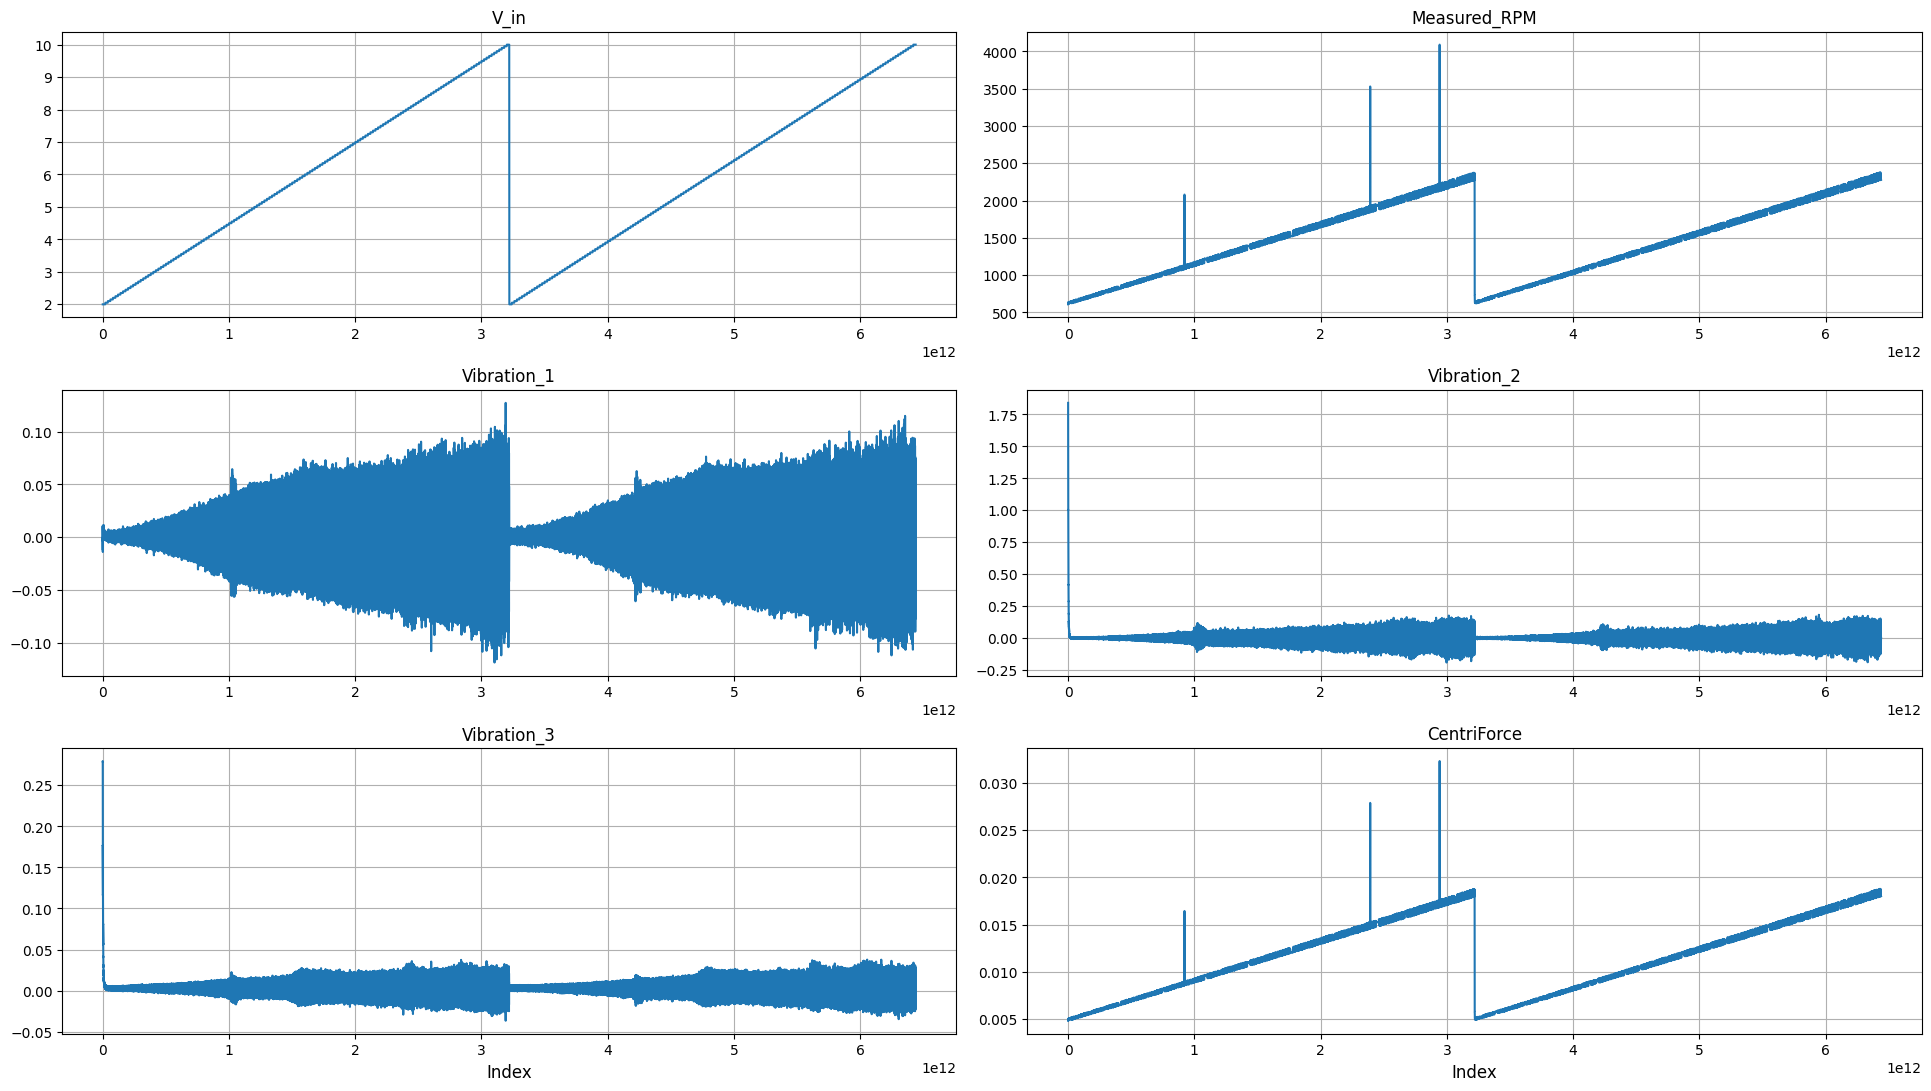

In [7]:
test.add_time(True)
vis.plot_columns_as_subplots(test.data, test.data.columns.values)

[607.52576]
607.52576
2048


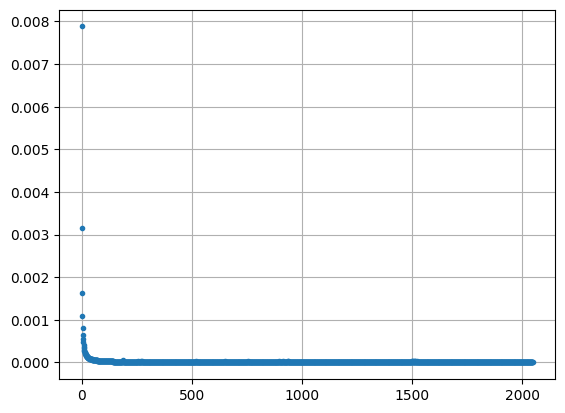

In [11]:
from statistics import fmean
n = 4095
dt = 1 / n
signal = test.data["Vibration_1"].iloc[0:n]
rpm = test.data["Measured_RPM"].iloc[0:n].unique()
print(rpm)
print(fmean(rpm))
y = np.fft.rfft(signal)
f = np.fft.rfftfreq(n=n,d=dt)
plt.plot(f, 1.0/n * np.abs(y), ".")

plt.grid()
print(len(y))
plt.show()

,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3
0,0.0,2.861023e+01,0.000000,0.000000,0.000000
10000,0.0,-2.400000e+08,0.219203,2.531375,0.573618
20000,2.0,6.449152e+02,0.019007,0.733600,0.147095
30000,2.0,6.378314e+02,0.013081,0.232453,0.052155
40000,2.0,6.375044e+02,0.008260,0.079712,0.022458
...,...,...,...,...,...
26350000,10.0,2.278077e+03,0.054388,0.016685,-0.002849
26360000,10.0,2.376473e+03,0.021167,0.022061,0.007240
26370000,10.0,2.341121e+03,-0.007980,0.012766,0.009121
26380000,10.0,2.376473e+03,0.038943,-0.001593,-0.009680


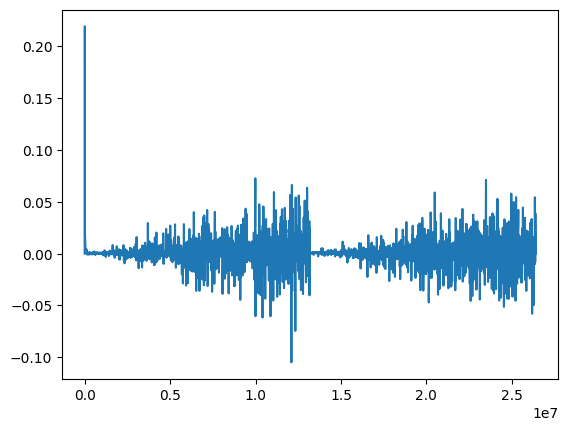

In [ ]:
#! WARNING: causes graphic card shutdown after ~80 minutes! 
#sns.pairplot(training_data[0])
#plt.show()
data_index = 4
vibration_index = 1
test = training_data[data_index].iloc[0::10000]
display(test)
# plt.plot(training_data[data_index][f"Vibration_{vibration_index}"].iloc[int(.01e7):])
plt.plot(test["Vibration_1"])
# plt.plot(training_data[3]["Vibration_2"])
# plt.plot(training_data[3]["Vibration_3"])
#training_data[3].hist(bins=15, figsize=(15,10))
#plt.tight_layout()
# sns.pairplot(test)
plt.show()

,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3
count,2.639053e+07,2.639053e+07,2.639053e+07,2.639053e+07,2.639053e+07
mean,5.997206e+00,-3.576920e+04,1.139313e-03,2.412792e-03,3.749252e-03
std,2.326852e+00,2.989759e+06,4.087136e-02,8.043873e-02,3.956148e-02
min,0.000000e+00,-2.400000e+08,-1.271856e-01,-2.047277e-01,-4.108310e-02
25%,4.000000e+00,1.052290e+03,-3.775358e-03,-4.433393e-03,4.947185e-04
50%,6.000000e+00,1.477250e+03,6.437302e-04,6.008148e-04,3.159046e-03
75%,8.000000e+00,1.905881e+03,5.478859e-03,5.640984e-03,5.917549e-03
max,1.000000e+01,3.830562e+03,6.833680e+00,8.469567e+00,6.548744e+00


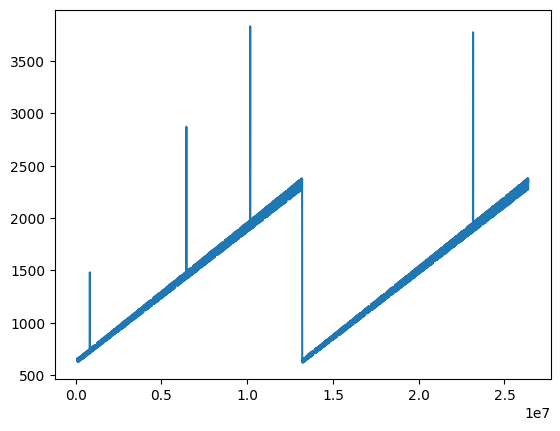

In [8]:
data_index = 4
vibration_index = 1
display(train_data[data_index].data.describe())
plt.plot(train_data[data_index].data["Measured_RPM"].iloc[int(.01e7):])
plt.show()

In [45]:
display(training_data[1].describe())

corr_matrix = training_data[1].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Korrelationsmatrix')
plt.show()

corr_matrix = training_data[1].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Korrelationsmatrix')
plt.show()


NameError: name 'training_data' is not defined

In [ ]:
print(type(training_data[1]["Time"]))
def differentiate(y: np.array, x: np.array, di: int = 1, mode: str = "central"):
    valid_modes = ["forward", "backward", "central"]
    if mode not in valid_modes:
        raise AttributeError(f"Selected mode invalid! Please choose one of the follwing:\t{valid_modes}")
    
    dydx = np.zeros(y.shape, dtype=np.float64)

    if mode == valid_modes[0]:
        for i in range(start=0, stop=dydx-di):
            dydx[i] = (y[i+di] - y[i]) / (x[i+di] - x[i])
    elif mode == valid_modes[1]:
        for i in range(start=di, stop=dydx.size):
            dydx[i] = (y[i] - y[i-di]) / (x[i] - x[i-di])
    elif mode == valid_modes[2]:
        for i in range(di, dydx.size-di):
            dydx[i] = (y[i+di] - y[i-di]) / (x[i+di] - x[i-di])


    display(dydx)

display(type(training_data[1]["Time"]))

display(training_data[1]["Time"].seconds() + training_data[1]["Time"].microseconds() / 10^6)

differentiate(y=training_data[1]["Measured_RPM"].to_numpy(dtype=np.float64), x=training_data[1]["Time"].dt.total_seconds())

<class 'pandas.core.series.Series'>


pandas.core.series.Series

AttributeError: 'Series' object has no attribute 'seconds'